In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
MODEL_NAME = "gpt-4.1-mini"

In [3]:
FILE_PATH = r"C:\Users\jongb\Documents\langchain-kr\MCP_PROJECTS\data\Samsung_Electronics_Sustainability_Report_2024_KOR.pdf"

In [ ]:
from rag.pdf import PDFRetrievalChain

# Load pdf
pdf = PDFRetrievalChain([FILE_PATH]).create_chain()

# set retriever
pdf_retriever = pdf.retriever

# build chain
pdf_chain = pdf.chain

### Retrieval Grader

In [5]:
from adaptiverag.retrievalgrader import retrievalgrader

retrieval_grader = retrievalgrader(MODEL_NAME)

### RAG chain for generating Answer

In [6]:
from adaptiverag.answerchain import answerchain

answer_chain = answerchain(MODEL_NAME)

### Hallucination Checker

In [7]:
from adaptiverag.hallucinationchecker import hallucinationchecker

hallucination_grader = hallucinationchecker(MODEL_NAME)

### Answer Checker

In [8]:
from adaptiverag.answerchecker import answerchecker

answer_grader = answerchecker(MODEL_NAME)

### Query Rewriter

In [9]:
from adaptiverag.queryrewriter import queryrewriter

query_rewriter = queryrewriter(MODEL_NAME)

## Build Graph

### Set State

In [10]:
from typing import List
from typing_extensions import TypedDict, Annotated


class GraphState(TypedDict):
    """
    Data Model for Representing the State of a Graph

    Attributes:
        question: User question
        generation: answer generated by LLM
        documents: Document list
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

### Set Workflow

### Build nodes

In [11]:
# Retrieval Node
def retrieve(state: GraphState) -> GraphState:
    print("==== [RETRIEVE] ====")
    question = state["question"]

    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# Answer Node
def generate(state: GraphState) -> GraphState:
    print("==== [GENERATE] ====")

    question = state["question"]
    documents = state["documents"]

    generation = answer_chain.invoke({"context": documents, "question": question})

    return {"generation": generation}


# Document Grader Node
def grade_documents(state: GraphState) -> GraphState:
    print("==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====")

    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)

        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}


# Query ReWriter Node
def transform_query(state: GraphState) -> GraphState:
    print("==== [TRANSFORM QUERY] ====")

    question = state["question"]

    # rewrite Query
    better_question = query_rewriter.invoke({"question": question})
    return {"question": better_question}

### Query router Node & relevance checker Node & Hallucination checker Node

In [ ]:
# Documents Relevance Checker Node
def decide_to_generate(state: GraphState) -> GraphState:
    print("==== [DECISION TO GENERATE] ====")

    filtered_documents = state["documents"]

    if not filtered_documents:
        # when all filtered docs is not relevant, rewrite query
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # when there are relevant docs, generate the answer
        print("==== [DECISION: GENERATE] ====")
        return "generate"


# Hallucination Checker Node
def halluciantion_check(state: GraphState) -> GraphState:
    print("\n==== [CHECK HALLUCINATIONS] ====\n")

    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # check hallucination
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    grade = score.binary_score

    if grade == "yes":
        print("\n==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====\n")

        # Answer relevance check
        print("\n==== [GRADE GENERATED ANSWER vs QUESTION] ====\n")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score

        if grade == "yes":
            print("\n==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====\n")
            return "relevant"
        else:
            print(
                "\n==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====\n"
            )
            return "not relevant"

    else:
        print(
            "\n==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====\n"
        )
        return "hallucination"

### Add nodes and Compile nodes

In [17]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# initialize graph
workflow = StateGraph(GraphState)

# add nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build workflow

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    halluciantion_check,
    {"hallucination": "generate", "relevant": END, "not relevant": "transform_query"},
)

app = workflow.compile(checkpointer=MemorySaver())

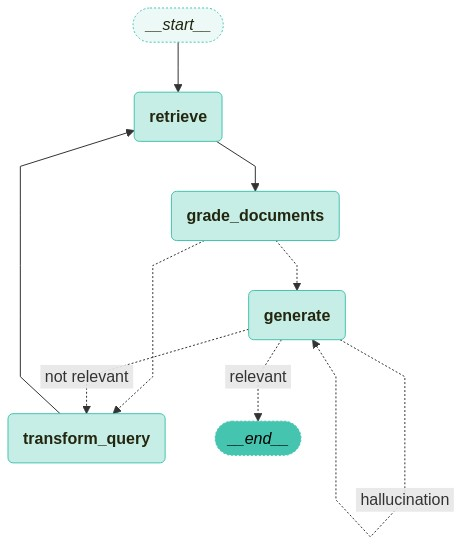

In [18]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

### Try to use Graph

In [19]:
from langchain_teddynote.messages import stream_graph, random_uuid
from langchain_core.runnables import RunnableConfig

# set config
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# query
inputs = {"question": "재생원료 사용 비율은 어떻게 돼?"}

stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])

==== [RETRIEVE] ====
==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
==== [DECISION TO GENERATE] ====
==== [DECISION: GENERATE] ====
==== [GENERATE] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자의 재생원료 사용 비율은 다음과 같습니다:

- 플라스틱 부품에 재생레진 적용 비율은 부품별로 다르나, 플라스틱 부품의 50% 이상을 2050년까지 목표로 하고 있습니다.
- 등급 기준으로 플래티넘은 100%, 골드는 95~99%, 실버는 90~94%, 인증은 80% 이상으로 구분하며, 99.5% 이상은 100%로 인정합니다.
- 폐기물 재활용 기술을 통해 고철, 재생 유리, 폐웨이퍼 실리콘 성분을 재생 알루미늄 합금 원료로 재활용하는 등 다양한 재생원료 활용을 확대하고 있습니다.

요약하면, 삼성전자는 플라스틱 부품에 대해 50% 이상의 재생레진 사용을 목표로 하며, 재생원료 사용 비율을 80% 이상부터 100%까지 등급별로 관리하고 있습니다.

- 출처: Samsung_Electronics_Sustainability_Report_2024_KOR.pdf,